# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
# Seaborn histplot does not seem to work 
# consulted Stackoverflow which suggested installing package direct then restarting kernel
# https://stackoverflow.com/questions/64815227/attributeerror-module-seaborn-has-no-attribute-histplot?rq=1

#!pip3 install seaborn==0.11.1

# Import data and packages required 

In [4]:
# import standard packages for manipulation
import pandas as pd
import numpy as np
import math
import json
from random import sample
% matplotlib inline

# packages for charting
import matplotlib.pyplot as plt
import seaborn as sns

# packages for dates and times
import datetime
from datetime import datetime
from datetime import date

# packages for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn import metrics


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Investigate and tidy Portfolio data

In [5]:
print("Portfolio has: " + str(portfolio.shape[0])+" rows, and "+str(portfolio.shape[1])+" columns")

portfolio.head(10)

Portfolio has: 10 rows, and 6 columns


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [6]:
# check the combinations of difficulty and reward for each offer type
print(portfolio.groupby(['offer_type','difficulty','reward'])['id'].count())

# check for missing data
print(portfolio.isnull().sum())

offer_type     difficulty  reward
bogo           5           5         2
               10          10        2
discount       7           3         1
               10          2         2
               20          5         1
informational  0           0         2
Name: id, dtype: int64
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


In [7]:
# add a descriptor for the offer type
portfolio['off_difredu']=portfolio['offer_type']+'_'\
                +portfolio['difficulty'].map(str)+'_'+\
                +portfolio['duration'].map(str)+'_'+\
                +portfolio['reward'].map(str)
                
# add a simple sequential offer number for grouping - use the index
portfolio['offer_num'] = "offer"+'_'+portfolio.index.map(str)

# convert duration to hours
portfolio['duration_hrs'] = portfolio['duration'].apply(lambda x: x*24)

# finally rename the id column to something more specific to this data
portfolio.rename(columns={'id':'offer id'}, inplace=True)

In [8]:
# check this frame
portfolio.head()

,channels,difficulty,duration,offer id,offer_type,reward,off_difredu,offer_num,duration_hrs
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_7_10,offer_0,168
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo_10_5_10,offer_1,120
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,informational_0_4_0,offer_2,96
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_7_5,offer_3,168
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,discount_20_10_5,offer_4,240


# Investigate and tidy the Profile data

In [9]:
# profile data
print("profile has: " + str(profile.shape[0])+" rows, and "+str(profile.shape[1])+" columns")

profile.head()

profile has: 17000 rows, and 5 columns


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
# check for missing data
print(profile.isnull().sum())

# gain descriptive statistics
print(profile['age'].describe())
print(profile['income'].describe())
print(profile['gender'].value_counts())


# there are customer with an age of 118 - this is not correct, how much data does this repersent?
np.sum(profile.age>=118)/profile.shape[0]

# 12% of the data has the value 118, which is the missing entries for income and gender 
# should this be removed? could be useful - investigate along with transactions.

# check for duplicate ids
id_list=list(profile['id'])
id_set=set(id_list)

assert len(id_list)==len(id_set) # no assertion error raised - id is unique


age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64
count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64
M    8484
F    6129
O     212
Name: gender, dtype: int64


There are a number of missing cases for Gender and Income. This is the same amount for those that have an Age of 118. These cases can be investigated further to identify if imputation would be valid or the data should be removed. 

By creating a variable 'complete' we can explore demographics and inormation available for those that have 'incomplete' information and compare to those that can 'complete' data. Explore this data alongside transactions and offers defore deciding to input or remove.

In [11]:
# create a feature showing if the profile is complete or incomplete
profile['complete']=np.where(profile['income'].isna() & profile['gender'].isna(),'incomplete','complete')

# for gender replace missing with unk
profile['gender'].fillna(value='UNK',inplace=True)

# use get dummies to rearrange this data
gender=pd.get_dummies(profile['gender']).add_prefix('gender_')

# concat the data together, dropping the original values and adding the new dummy variables
profile=pd.concat([profile,gender],axis=1)

# change became member to date time variable
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# add feature to represent 'tenure' - we will assum the data is relevant as of today
today = date.today().strftime('%Y-%m-%d')
today = pd.to_datetime(today,format='%Y-%m-%d')

profile['tenure'] = (today-pd.DatetimeIndex(profile['became_member_on'])).days


In [12]:
# check the data is now formatted correctly
profile.head()

,age,became_member_on,gender,id,income,complete,gender_F,gender_M,gender_O,gender_UNK,tenure
0,118,2017-02-12,UNK,68be06ca386d4c31939f3a4f0e3dd783,NaN,incomplete,0,0,0,1,1619
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,complete,1,0,0,0,1466
2,118,2018-07-12,UNK,38fe809add3b4fcf9315a9694bb96ff5,NaN,incomplete,0,0,0,1,1104
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,complete,1,0,0,0,1533
4,118,2017-08-04,UNK,a03223e636434f42ac4c3df47e8bac43,NaN,incomplete,0,0,0,1,1446


# Investigate and tidy the Transcript data

In [13]:
## what does the shape look like? 
print("transcript has: " + str(transcript.shape[0])+" rows, and "+str(transcript.shape[1])+" columns")

# values of the event columns
print(transcript.event.value_counts())

transcript.head()


transcript has: 306534 rows, and 4 columns
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
# extract item out of the dictionary and store it as new field 
fields=['offer id','amount']

# iterate through a field list, access the dictionary using 'get' - use lambda to apply this to a new field
for var in fields:
    transcript[var] = transcript['value'].apply(lambda x: x.get(var))

# drop value - no longer required
transcript.drop(['value'],axis=1,inplace=True)

# create a duplicate offer-id - we will use this to compare when the offer was on/not on
transcript['offer']=transcript['offer id']
transcript=transcript.sort_values(by=['person','time'])

# fill forward the offer - this provides the window  until then next offer was recevied - add duration to check valid
# Assumption: The cusotmer is influenced by an offer until the next offer is received. 
transcript['offer'] = transcript['offer'].ffill()


Above we have used Fill Forward. The id for the offer only appreads when it is received, viewed or completed. In using Fill Forward we are assuming that the customer is being infuenced by the offer until the next offer is received. Transactions occuring from when an offer is received to one the next offer is received are then assigned to set 'windows'. It is then possible to consider whether a transaction was valid within the the window period.


# Create sample data for testing and population data

In [15]:
# create a list of all persons within the data 
customers=list(set(transcript['person']))
print("Number of customers: "+str(len(customers)))


# there are 17k customers - build on a random sample then test
customers_samp=sample(customers,10000)
print("My sample to test:" +str(len(customers_samp)))

Number of customers: 17000
My sample to test:10000


In [16]:
#test_person=['b895c57e8cd047a8872ce02aa54759d6','e2127556f4f64592b11af22de27a7932']

transcript_cpy=transcript

# create a blank data frame - we will append each person to the file as we calculate their time windows
transcript_win = pd.DataFrame([])
counter=0

for ppl in customers:
    transcript_per=transcript_cpy[transcript_cpy['person']==ppl].sort_values(by=['time'])
       
    # create a concept of a 'block' this is the collection of transaction from when an offer is issued to the next
    transcript_per['block'] = (transcript_per['offer'] != transcript_per['offer'].shift(1)).astype(int).cumsum()
           
    # take the lag of time for each block - we can then compare when once block stops and another starts
    shift_time=transcript_per.groupby(['block'])['time'].shift(periods=1)
        
    # if the time is not eq to the lag time use 0 else take the difference
    transcript_per['window_diffs']= np.where((transcript_per['time']==shift_time),\
                                             0,transcript_per['time']-shift_time)
      
    # append this person batch on to the blank frame
    transcript_win=transcript_win.append(transcript_per)
        
    #counter+=1
    #print(counter)
    
# finally we now need to get the cummulative amount for each window diff
transcript_win['window_diffs'].fillna(0,inplace=True)
transcript_win['window_diffs2']=transcript_win.groupby(['person','block'])['window_diffs'].cumsum()

# Attach Portfolio data and checking validity period

In [17]:
# join the portfolio data - we only require duration and offer to check validity windows

# transcript - long file with multiple rows per person
# portfolio - provides the offer types

# key to join Left: offer id, Right: offer_id
trans_offer=pd.merge(transcript_win,portfolio[['offer id','duration_hrs']], how='left', left_on='offer',right_on='offer id')

# was the offer valid at the time the transaction was used?
trans_offer['valid']=np.where(trans_offer['window_diffs2']-trans_offer['duration_hrs']<0,'In offer','Out offer')

In [18]:
# gain the total amount of monies that occured in the blocks
sums=trans_offer.groupby(['person','block','event','valid'])['amount'].sum()
sum_df=pd.DataFrame(sums).reset_index()

With the transactions and offers merged we can now look at the transaction amounts. Using the 'valid' offer we will create total total transaction amounts by this group. 

We will also create new features showing the total transactions sum and also the cummulative amounts spent. The cummulative amount spent will be based on a lag value - thus, it is the total amount spent prior to the next 'block window' occuring when a new offer is issued. The hypothesis is that the sum of the monies spent prior to an offer being issued is important in deciding whether to accept the next offer.

In [19]:
# unstack and join back to main source - data now has indicator if transaction total was in offer or out

# use dummies on event 
event=pd.get_dummies(sum_df['event'])
event=event[['offer received','offer viewed','offer completed','transaction']]


# concat the data together, dropping the original values and adding the new dummy variables
transcript_oneline=pd.concat([sum_df.drop(['event'],axis=1),event],axis=1)
 
# sum by the person and the block to gain total amounts for transactions and activity    
transcript_oneline=pd.DataFrame(transcript_oneline.groupby(['person','block','valid']).sum()).reset_index()

# split the data so there is a frame for in and out - create totals for amounts associated with each
transcript_in=transcript_oneline[transcript_oneline['valid']=='In offer'].rename(columns={'amount':'in_offer_amt'}).\
            drop('valid',axis=1)

transcript_out=transcript_oneline[transcript_oneline['valid']=='Out offer'].rename(columns={'amount':'out_offer_amt'}).\
            drop(['valid','offer received','offer viewed','offer completed','transaction'],axis=1)

# merge both the in offer and out of offer frames together
transcript_fin=pd.merge(transcript_in,transcript_out, how='left', on=['person','block'])

# create a new feature showing amounts spent at the previous offer and cumulatitive amounts spent on offers
transcript_fin['total_trans']=transcript_fin['in_offer_amt'].fillna(0)+transcript_fin['out_offer_amt'].fillna(0)
transcript_fin['prev_offer_amt']=transcript_fin.groupby(['person'])['total_trans'].shift(periods=1)
transcript_fin['cum_offer_amt']=transcript_fin.groupby(['person'])['prev_offer_amt'].cumsum()


# Join all sources of data together

We now have our transactions for each customer arranged into 'windows' based on the time they received the offer. Each window has an offer or 'no offer' along with monies spent in offer and out of offer.

The remaining portfolio data and profile information can now be added

In [20]:
# now attach on rest of portfolio data as well as customer data

# merge by person and block
# join 1 - use transcript_win to gain offer id for the block
trans=pd.merge(transcript_fin,transcript_win[['person','offer id','block']].drop_duplicates().dropna(),\
                    how='left',on=['person','block'])

# join 2 - use portfolio for the offer types
trans_offers=pd.merge(trans,portfolio.drop(['duration','duration_hrs'],axis=1),how='left',on='offer id')

# join 3 - add on customer information
starbucks=pd.merge(trans_offers,profile,how='left',left_on='person',right_on='id')

# check the columns within the frame
print(starbucks.columns)

print("")
# how does my starbucks frame look
print("starbucks has: " + str(starbucks.shape[0])+" rows, and "+str(starbucks.shape[1])+" columns")

Index(['person', 'block', 'in_offer_amt', 'offer received', 'offer viewed',
       'offer completed', 'transaction', 'out_offer_amt', 'total_trans',
       'prev_offer_amt', 'cum_offer_amt', 'offer id', 'channels', 'difficulty',
       'offer_type', 'reward', 'off_difredu', 'offer_num', 'age',
       'became_member_on', 'gender', 'id', 'income', 'complete', 'gender_F',
       'gender_M', 'gender_O', 'gender_UNK', 'tenure'],
      dtype='object')

starbucks has: 72658 rows, and 29 columns


# Missing entries in main data

On the main starbucks frame, we can now explore and impute or remove missing information

In [21]:
# drop fields not requried: 'offer id','id'
starbucks.drop(['id','offer id'],axis=1,inplace=True)

# check for missing information
print(starbucks.isnull().sum())


person                  0
block                   0
in_offer_amt            0
offer received          0
offer viewed            0
offer completed         0
transaction             0
out_offer_amt       58495
total_trans             0
prev_offer_amt      17000
cum_offer_amt       17000
channels             2330
difficulty           2330
offer_type           2330
reward               2330
off_difredu          2330
offer_num            2330
age                     0
became_member_on        0
gender                  0
income               9272
complete                0
gender_F                0
gender_M                0
gender_O                0
gender_UNK              0
tenure                  0
dtype: int64


In [22]:
# for offer replace missing with no offer
starbucks.fillna({'offer_type':'No offer', 'off_difredu':'No offer', 'offer_num':'No offer'}, inplace=True)

# set difficulty, reward and duration to 0 - there was no offer so these could be 0
starbucks.fillna({'difficulty':0, 'reward':0, 'duration':0}, inplace=True)

# where the out of offer amount, orev or cum amounts = na then fill with 0
starbucks.fillna({'out_offer_amt':0, 'prev_offer_amt':0, 'cum_offer_amt':0}, inplace=True)

# use get_dummies on the offer type and the channel type, also the offers with difficulty and reward
offers=pd.get_dummies(starbucks['offer_type'],dummy_na=True).add_prefix('offer_')
offers_detail=pd.get_dummies(starbucks['off_difredu'],dummy_na=True).add_prefix('type_')

channels=starbucks.channels.str.join('|').str.get_dummies().add_prefix('chan_')

## check for duplicates when merging
dupes=starbucks.groupby(['person','block'])['person'].count()
assert np.sum(dupes>1) ==0

# concat all data together
starbucks=pd.concat([starbucks.drop(['channels'],axis=1),offers,offers_detail,channels],axis=1)


In [23]:
# check for missing information
print(starbucks.isnull().sum())


person                         0
block                          0
in_offer_amt                   0
offer received                 0
offer viewed                   0
offer completed                0
transaction                    0
out_offer_amt                  0
total_trans                    0
prev_offer_amt                 0
cum_offer_amt                  0
difficulty                     0
offer_type                     0
reward                         0
off_difredu                    0
offer_num                      0
age                            0
became_member_on               0
gender                         0
income                      9272
complete                       0
gender_F                       0
gender_M                       0
gender_O                       0
gender_UNK                     0
tenure                         0
offer_No offer                 0
offer_bogo                     0
offer_discount                 0
offer_informational            0
offer_nan 

In [24]:
## investiagte the missing information in income    
missing_inc=starbucks[starbucks['income'].isna()]

missing_inc['complete'].value_counts() # customers with missing income are entierly 'incomplete' customers


incomplete    9272
Name: complete, dtype: int64

In [25]:
# investigate incomplete customers
print(missing_inc.groupby('complete')['person'].nunique())


# what type of offers were Incompete sent and what is this as a proportion as the total?
incomp_off=missing_inc.groupby(['complete','offer_type'])['person'].count()

print(incomp_off)

print("")

incomp_pcts = incomp_off.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
print(incomp_pcts)

# and how successful were incomplete cusotmers when given offers?

# Q. How many offers were received and the customers that viewed them 
rec= missing_inc['offer received']==1
view=missing_inc['offer viewed']==1

rec_to_view=np.sum(rec&view)
# proportion of receives that went to view 
print("%of receives that converted to a view: "+str(rec_to_view.sum()/rec.sum()))

# Q. How many completions occured once an offer was viewed 
comp= missing_inc['offer completed']==1

view_to_comp=np.sum(view&comp)

print("")
# proportion of views that went to a complete 
print("%of views that converted to a complete: "+str(view_to_comp.sum()/view.sum()))


print("")
# and how well did offers perform for incomplete customers
# how much is their total spend compared to complete customers?
print(missing_inc.groupby('off_difredu')['offer completed','in_offer_amt','out_offer_amt','tenure'].mean())


complete
incomplete    2175
Name: person, dtype: int64
complete    offer_type   
incomplete  No offer          272
            bogo             3640
            discount         3565
            informational    1795
Name: person, dtype: int64

complete    offer_type   
incomplete  No offer          2.933563
            bogo             39.257981
            discount         38.449094
            informational    19.359362
Name: person, dtype: float64
%of receives that converted to a view: 0.790234679123568

%of views that converted to a complete: 0.11597466572836031

                     offer completed  in_offer_amt  out_offer_amt       tenure
off_difredu                                                                   
No offer                    0.000000      3.897647       0.629890  1582.338235
bogo_10_5_10                0.049451      3.212275       0.915989  1585.473626
bogo_10_7_10                0.068889      4.170678       0.485433  1569.104444
bogo_5_5_5                  0.

# Remove missing entries

Incomplete cases make up 12% of this data, and the response to an offer when it is viewed is also low, with some offers having a response only 4%, compared to the compete group which is ~50%. The average monies spent to are also low in comparisson to the complete group. In recommending offers - we could create a rule where customers with incomplete details are not offered promotions. 

It is decided to remove cases that are 'incomplete'. Imputation was considered, but with 12% of the data missing, imputating the mean age may not be a reasonable and isntead focus result around the mean.  

In [26]:
starbucks.dropna(inplace=True)

# what is the shape of my final data
print("starbucks has: " + str(starbucks.shape[0])+" rows, and "+str(starbucks.shape[1])+" columns")

# gain snap shot of one customer
starbucks[starbucks['person']=='0009655768c64bdeb2e877511632db8f']


starbucks has: 63386 rows, and 47 columns


,person,block,in_offer_amt,offer received,offer viewed,offer completed,transaction,out_offer_amt,total_trans,prev_offer_amt,...,type_discount_10_7_2,type_discount_20_10_5,type_discount_7_7_3,type_informational_0_3_0,type_informational_0_4_0,type_nan,chan_email,chan_mobile,chan_social,chan_web
0,0009655768c64bdeb2e877511632db8f,1,22.16,1,1,0,1,0.0,22.16,0.00,...,0,0,0,1,0,0,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,2,0.00,1,1,0,0,0.0,0.00,22.16,...,0,0,0,0,1,0,1,1,0,1
2,0009655768c64bdeb2e877511632db8f,3,8.57,1,1,1,1,0.0,8.57,0.00,...,0,0,0,0,0,0,1,1,1,1
3,0009655768c64bdeb2e877511632db8f,4,27.67,1,1,1,1,0.0,27.67,8.57,...,0,0,0,0,0,0,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,5,69.20,1,0,1,1,0.0,69.20,27.67,...,1,0,0,0,0,0,1,1,0,1


# Exploratory Data Analysis

The response variable we are measuring is: proportion of offers viewed that led to completion

Customers can be provided with more that one offer throughout the experiment, therefore completion can occur more that once too. Instead of counting distinct customers instead count the number of 'touch points'. A touch point is any interaction starbucks has had with a customer. If a customer has been sent 5 offers over the experiment then there has been 5 'touch points' with this customer. 

Total customers: 14825
Total touch points: 63386


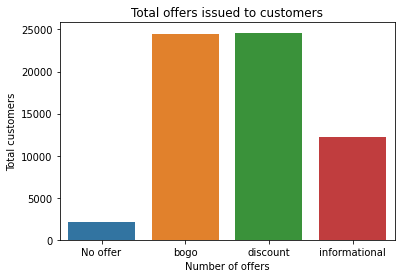

      offer_type  person   percent
0       No offer    2058  0.138820
1           bogo   13082  0.882428
2       discount   13042  0.879730
3  informational    9200  0.620573


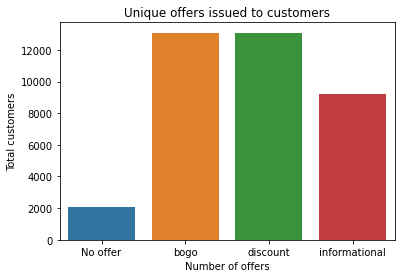

      offer_type  person   percent
0       No offer    2058  0.138820
1           bogo   13082  0.882428
2       discount   13042  0.879730
3  informational    9200  0.620573


In [27]:
# how many customers do we have?
total_cust=len(np.unique(starbucks.person))
print("Total customers: "+str(total_cust))

# how many customer touch points are there? A touch point is a collection of rows
total_touch=len(starbucks.person)
print("Total touch points: "+str(total_touch))

# distribution of customers to offer
bar_offer=pd.DataFrame(starbucks.groupby('offer_type')['person'].count()).reset_index()

ax = sns.barplot(x="offer_type", y="person", data=bar_offer)
plt.xlabel('Number of offers')
plt.ylabel('Total customers')
plt.title('Total offers issued to customers')
plt.show()


# count distinct offers to customers (i.e. if a cusotmer is issued 'discount' twice we count this as 1)
# distribution of customers to offer
bar_offer_unq=pd.DataFrame(starbucks.groupby('offer_type')['person'].nunique()).reset_index()

#percentages of unique customers to offers
bar_offer_unq['percent']=bar_offer_unq['person']/total_cust
print(bar_offer_unq)

ax = sns.barplot(x="offer_type", y="person", data=bar_offer_unq)
plt.xlabel('Number of offers')
plt.ylabel('Total customers')
plt.title('Unique offers issued to customers')
plt.show()


specific_off_unq=pd.DataFrame(starbucks.groupby('off_difredu')['person'].nunique()).reset_index()

#percentages of unique customers to offers
specific_off_unq['percent']=bar_offer_unq['person']/total_cust
print(bar_offer_unq)




# How successful were our offers?

In [28]:
# number of customer connections
print("Total touch points: "+str(total_touch))

# number of offers received
off_rec_tot=starbucks['offer received'].sum()
off_rec_avg=starbucks['offer received'].mean()
print("Total offers received: "+str(off_rec_tot)+ " , which is "+str(off_rec_avg))

# number of receives that resulted in a view
rec= starbucks['offer received']==1
view=starbucks['offer viewed']==1

starbucks['rec_to_view']= starbucks.apply(lambda row: row['offer received'] * row['offer viewed'], axis=1)
rec_to_view=np.sum(starbucks['rec_to_view']==1)


print("")
print("Number of views that resulted when an offer was received: "+str(rec_to_view))


# proportion of receives that went to view 
print("%of receives that converted to a view: "+str(rec_to_view/rec.sum()))


# number of completions that resulted after a view (assuming customer must receive to view)
comp=starbucks['offer completed']==1

starbucks['view_to_comp']= starbucks.apply(lambda row: row['offer completed'] * row['offer viewed'], axis=1)
view_to_comp=np.sum(starbucks['view_to_comp']==1)


print("")
print("Number of completions that resulted when an offer was viewed: "+str(view_to_comp))

# proportion of views that went to comps 
print("%of views that converted to a completion: "+str(view_to_comp.sum()/view.sum()))



Total touch points: 63386
Total offers received: 61245 , which is 0.966222825229546

Number of views that resulted when an offer was received: 45042
%of receives that converted to a view: 0.7354396277247123

Number of completions that resulted when an offer was viewed: 22931
%of views that converted to a completion: 0.5091026153367968


# Which Demographics and offers had the best response?

In [29]:
starbucks_views=starbucks[starbucks['offer viewed']==1]

print("")
print(starbucks_views.groupby(['offer_type','gender'])['offer completed'].mean())

print("")
print(starbucks_views.groupby(['off_difredu'])['offer completed','income','in_offer_amt','out_offer_amt', 'prev_offer_amt','cum_offer_amt'].mean())




offer_type     gender
bogo           F         0.649039
               M         0.484922
               O         0.658703
discount       F         0.715500
               M         0.601986
               O         0.659341
informational  F         0.074585
               M         0.075198
               O         0.125000
Name: offer completed, dtype: float64

                     offer completed        income  in_offer_amt  \
off_difredu                                                        
bogo_10_5_10                0.489127  65533.137729     24.197639   
bogo_10_7_10                0.515832  63884.572901     28.943444   
bogo_5_5_5                  0.586669  65558.649495     23.713815   
bogo_5_7_5                  0.687363  67426.209048     30.174059   
discount_10_10_2            0.645367  65485.118547     36.392795   
discount_10_7_2             0.674820  68624.647225     32.112242   
discount_20_10_5            0.573755  69794.540230     36.715469   
discount_7_7_3      

# Distribution of Ages, Incomes and Tenure

Gain a distribution for when view convereted and when didn't convert 

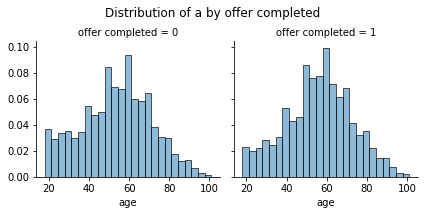

In [30]:
# Create a histogram for ages
g = sns.FacetGrid(starbucks_views, col="offer completed")
g.map(sns.histplot, "age", bins=25, alpha=0.5, stat='probability')
g.fig.suptitle('Distribution of a by offer completed')
g.fig.subplots_adjust(top=0.82) 

g
plt.show()


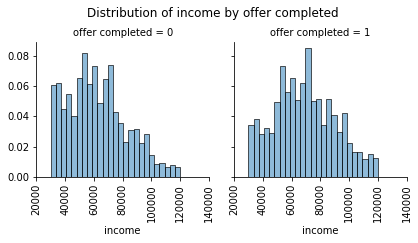

In [31]:
# Create a histogram for income
g2 = sns.FacetGrid(starbucks_views, col="offer completed")
g2.map(sns.histplot, "income", bins=25, alpha=0.5, stat='probability')
g2.fig.suptitle('Distribution of income by offer completed')
g2.fig.subplots_adjust(top=0.82) 
g2.set_xticklabels(rotation=90)
g2
plt.show()


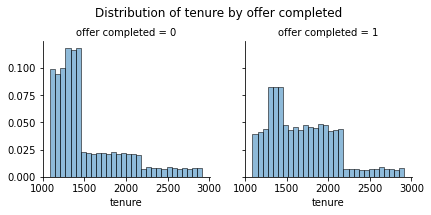

In [32]:
g3 = sns.FacetGrid(starbucks_views, col="offer completed")
g3.map(sns.histplot, "tenure", bins=30, alpha=0.5, stat='probability')
g3.fig.suptitle('Distribution of tenure by offer completed')
g3.fig.subplots_adjust(top=0.82) 
#g3.set_xticklabels(rotation=90)
g3
plt.show()




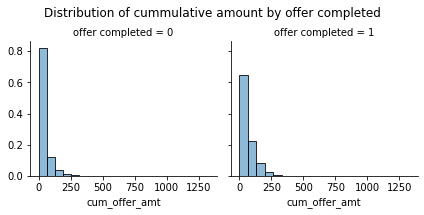

In [33]:
g4 = sns.FacetGrid(starbucks_views, col="offer completed")
g4.map(sns.histplot, "cum_offer_amt", bins=20, alpha=0.5, stat='probability')
g4.fig.suptitle('Distribution of cummulative amount by offer completed')
g4.fig.subplots_adjust(top=0.82) 
#g3.set_xticklabels(rotation=90)
g4
plt.show()

In [34]:
# describe the continuous variables by offer complete
describe_sums = ['age','income','tenure','cum_offer_amt']

for cols in describe_sums:
    print(cols)
    print(starbucks_views.groupby(['offer completed'])[cols].describe())

age
                   count       mean        std   min   25%   50%   75%    max
offer completed                                                              
0                22111.0  53.440052  17.516738  18.0  41.0  54.0  66.0  101.0
1                22931.0  55.790502  16.705775  18.0  45.0  56.0  67.0  101.0
income
                   count          mean           std      min      25%  \
offer completed                                                          
0                22111.0  62297.951246  20362.043219  30000.0  47000.0   
1                22931.0  69121.582138  21133.809387  30000.0  53000.0   

                     50%      75%       max  
offer completed                              
0                60000.0  75000.0  120000.0  
1                68000.0  84000.0  120000.0  
tenure
                   count         mean         std     min     25%     50%  \
offer completed                                                             
0                22111.0  1538.7047

# Building a model - predicting completion after view

We will now build a predictive model to predict customers that will likely compelte an offer once they have viewed the offer. First we will check for correlations between variables and remove any which are highly correlated. Accuracy and F1 score will be used to gauge success of the model along with the AUC score. Variable importance will also be outputted.

Monies from transactions was considered as a predictor, but discounted as it in-effect describes the response. Those that have higher sales transactions tend to complete offers. Additonally, in providing offers to new customers, information about their total sales is not known at the point the offer is issued. 

In [35]:
print(starbucks_views.columns)

Index(['person', 'block', 'in_offer_amt', 'offer received', 'offer viewed',
       'offer completed', 'transaction', 'out_offer_amt', 'total_trans',
       'prev_offer_amt', 'cum_offer_amt', 'difficulty', 'offer_type', 'reward',
       'off_difredu', 'offer_num', 'age', 'became_member_on', 'gender',
       'income', 'complete', 'gender_F', 'gender_M', 'gender_O', 'gender_UNK',
       'tenure', 'offer_No offer', 'offer_bogo', 'offer_discount',
       'offer_informational', 'offer_nan', 'type_No offer',
       'type_bogo_10_5_10', 'type_bogo_10_7_10', 'type_bogo_5_5_5',
       'type_bogo_5_7_5', 'type_discount_10_10_2', 'type_discount_10_7_2',
       'type_discount_20_10_5', 'type_discount_7_7_3',
       'type_informational_0_3_0', 'type_informational_0_4_0', 'type_nan',
       'chan_email', 'chan_mobile', 'chan_social', 'chan_web', 'rec_to_view',
       'view_to_comp'],
      dtype='object')


In [36]:
keep_cols=['age','income','gender_F',
       'gender_M', 'gender_O', 'gender_UNK','tenure',
        'type_No offer', 'type_bogo_10_5_10', 'type_bogo_10_7_10',
       'type_bogo_5_5_5', 'type_bogo_5_7_5', 'type_discount_10_10_2',
       'type_discount_10_7_2', 'type_discount_20_10_5', 'type_discount_7_7_3',
       'type_informational_0_3_0', 'type_informational_0_4_0', 'type_nan',
        'chan_email', 'chan_mobile', 'chan_social', 'chan_web','prev_offer_amt','cum_offer_amt']

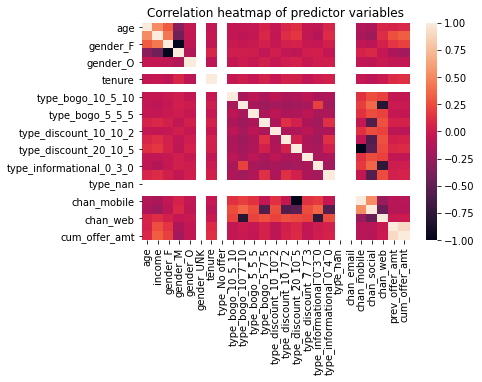

In [37]:
# investigate heat map for correlations
corrs=starbucks_views[keep_cols].corr()
sns.heatmap(corrs.corr())
plt.title('Correlation heatmap of predictor variables')
plt.show()


In [38]:
# remove gender_unk, type_no offer and chan_email - offer amounts are highly correlated with each other
keep_cols=['age','income','gender_F',
       'gender_M', 'gender_O', 'tenure',
        'type_bogo_10_5_10', 'type_bogo_10_7_10',
       'type_bogo_5_5_5', 'type_bogo_5_7_5', 'type_discount_10_10_2',
       'type_discount_10_7_2', 'type_discount_20_10_5', 'type_discount_7_7_3',
       'type_informational_0_3_0', 'type_informational_0_4_0', 
        'chan_mobile', 'chan_social', 'chan_web','cum_offer_amt']

In [39]:
# create y, the response and X the predictor variables
y=starbucks_views['offer completed'].values
X=starbucks_views[keep_cols].values


In [40]:
# split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# set the classifier

#clf=LogisticRegression()
#clf=RandomForestClassifier(n_estimators=50)

# fit the classifier to the training data
#clf.fit(X_train, y_train)  

# output predicted results for y
#y_pred=clf.predict(X_test)


In [41]:
# a short function to try out two differnt classifiers 
def modeltype (mod,descript):
    ''' Description: The purpose of this function is to create summary and evaluation statistics for 
    differnt types of model, with the results being outptutted
    
    Inputs: there are only 2 inputs required
        mod - allows the user to select the classifier
        descript - allows the user to provide a description of the model
    
    Outputs: returned items are
        y_pred - the predicted results
        clf - the clasifier used
    '''
    
    clf=mod
        
    # fit the classifier to the training data
    clf.fit(X_train, y_train)  

    # output predicted results for y
    y_pred=clf.predict(X_test)
    
    # gain an accuracy score and also classification report
    print("Accuracy for: "+str(descript), metrics.accuracy_score(y_test, y_pred))
    print("")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    
    # construct an AUC chart to represent model performance
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    # output the AUC value
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    # construct an AUC chart of the false postive rate and true postive rate
    plt.plot(fpr,tpr,label="Offers completed, auc="+str(auc))
    plt.title("AUC: "+str(descript))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc=4)
    plt.show()
    
    return y_pred,clf
       

Accuracy for: Logistic Regression 0.5847615664683421

             precision    recall  f1-score   support

          0       0.59      0.51      0.55      5570
          1       0.58      0.66      0.62      5691

avg / total       0.59      0.58      0.58     11261

[[2817 2753]
 [1923 3768]]


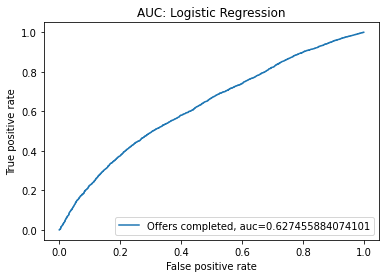

Accuracy for: Random Forest 0.7359026729420123

             precision    recall  f1-score   support

          0       0.72      0.75      0.74      5570
          1       0.75      0.72      0.73      5691

avg / total       0.74      0.74      0.74     11261

[[4186 1384]
 [1590 4101]]


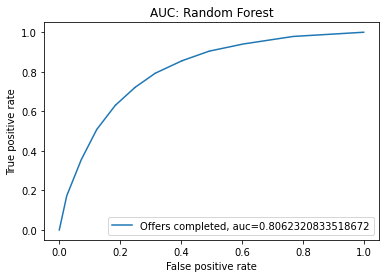

(array([0, 1, 0, ..., 0, 1, 1], dtype=uint8),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [42]:
# run the function to output two sets of results
modeltype(LogisticRegression(),descript="Logistic Regression")
modeltype(RandomForestClassifier(),descript="Random Forest")


The Logistic Regression model had a slightly worse Accuracy compared to the Random Forest. The precision in identifying the True cases is much higher with Random Forest - refine this model 

In [43]:
#preform grid search to identiy best number of of estimators

# check the baseline parameters
#clf.get_params()

# set the classifier to use
clf=RandomForestClassifier()

# create the grid to search through 
parameters={'n_estimators':[10,50,100,150]}

cv=GridSearchCV(clf,param_grid=parameters)
cv.fit(X_train,y_train)

# output the best estimators from the fitted model
cv.best_estimator_


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy for: Random Forest with 150 estimators 0.7571263653316757

             precision    recall  f1-score   support

          0       0.77      0.73      0.75      5570
          1       0.75      0.78      0.77      5691

avg / total       0.76      0.76      0.76     11261

[[4068 1502]
 [1233 4458]]


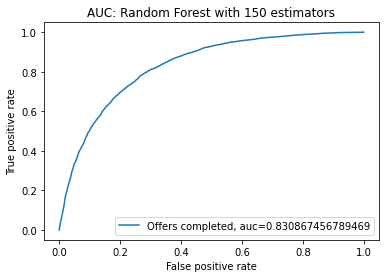

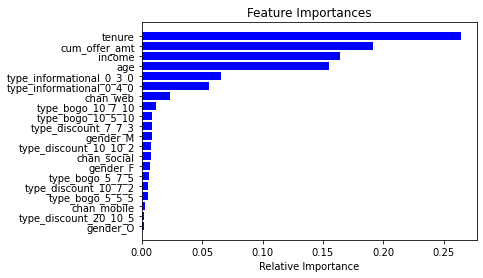

In [44]:
# rebuild model with n_estimators as 150
y_pred, clf=modeltype(RandomForestClassifier(n_estimators=150),descript="Random Forest with 150 estimators")


# plot feature importance
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
features = keep_cols
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


##### END